> ### EEE4423: Deep Learning Lab

# LAB \#3: CNN: VGG Net and ResNet

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-03-24 01:07:05.226248


## 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping.
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>>
>> <table><tr>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1jn7ICUJAcTF3WQ1XuUffOdmprgj4u1c3" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1Rz0iWW6VoLD_XGdRa3ofYyhCTTb6kR_k" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets 
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='../dataset/lab03', 
                            train=True, 
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='../dataset/lab03', 
                           train=False, 
                           transform=transform_test)

STEP 1: LOADING DATASET
Files already downloaded and verified


In [4]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))
        
reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [5]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [6]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

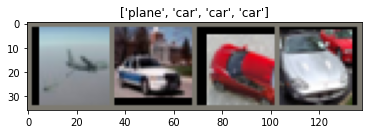

In [9]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=4, 
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.1 Write code (VGG 16) [3 points]

In [10]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

print('STEP 3: CREATE MODEL CLASS (VGG16)')
# ReLU activation
# batch-normalization after every convolution

class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    
    self.features = nn.Sequential(
        # Convolution 1-1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # Convolution 1-2
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # Max pool 1
        nn.MaxPool2d(kernel_size=2),

        # Convolution 2-1
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # Convolution 2-2
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # Max pool 2
        nn.MaxPool2d(kernel_size=2),

        # Convolution 3-1
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # Convolution 3-2
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # Convolution 3-3
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # Max pool 3
        nn.MaxPool2d(kernel_size=2),

        # Convolution 4-1
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        # Convolution 4-2
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        # Convolution 4-3
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        # Max pool 4
        nn.MaxPool2d(kernel_size=2),

        # Convolution 5-1
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        # Convolution 5-2
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        # Convolution 5-3
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        # Max pool 5
        nn.MaxPool2d(kernel_size=2)
    )
    # Fully connected (readout)
    self.fc1 = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 3)
        )


  def forward(self, x):
    features = self.features(x)
    out = features.view(features.size(0), -1)
    out = self.fc1(out)

    return out


STEP 3: CREATE MODEL CLASS (VGG16)
STEP 3: CREATE MODEL CLASS (VGG16)


In [11]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  33617987


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [12]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [13]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

import time

for epoch in range(num_epochs):
  start_time = time.time()
  for i, (images, labels) in enumerate(train_loader):
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    images = images.to(device)
    labels = labels.to(device)

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()
    
    # Forward pass to get output/logits
    outputs = model(images)

    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

  # Calculate Accuracy for each epoch 
  total = 0
  correct = 0
  for images, labels in test_loader:
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)

    if not torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum()
    else:
        correct += (predicted == labels).sum()

  accuracy = 100 * correct.item() / total

  print('epochs: {}. Loss: {}. Accuracy: {}. Elapsed time: {} sec'.format(epoch, loss.item(), accuracy, time.time() - start_time))


STEP 7: TRAIN THE MODEL


/home/jovyan/.venv/torch1.9.0-py3.8-cuda11.1/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epochs: 0. Loss: 0.4236792325973511. Accuracy: 82.46666666666667. Elapsed time: 3.6178839206695557 sec
epochs: 1. Loss: 0.27454277873039246. Accuracy: 86.83333333333333. Elapsed time: 3.4340834617614746 sec
epochs: 2. Loss: 0.5849425792694092. Accuracy: 88.4. Elapsed time: 3.464014768600464 sec
epochs: 3. Loss: 0.21393656730651855. Accuracy: 89.23333333333333. Elapsed time: 3.4569413661956787 sec
epochs: 4. Loss: 0.15223143994808197. Accuracy: 91.9. Elapsed time: 3.462792158126831 sec
epochs: 5. Loss: 0.07976546138525009. Accuracy: 91.23333333333333. Elapsed time: 3.4708542823791504 sec
epochs: 6. Loss: 0.37168216705322266. Accuracy: 87.43333333333334. Elapsed time: 3.4536354541778564 sec
epochs: 7. Loss: 0.13988913595676422. Accuracy: 91.6. Elapsed time: 3.4111123085021973 sec
epochs: 8. Loss: 0.031430684030056. Accuracy: 92.1. Elapsed time: 3.4770517349243164 sec
epochs: 9. Loss: 0.02712276764214039. Accuracy: 92.4. Elapsed time: 3.4607980251312256 sec
epochs: 10. Loss: 0.01420616265

## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1l3rC40WnBXZBagFIuME48SPvcqVY-56Y" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1r92UcNqn6ZT5pOk3emEijjTKlWdAYvCk" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="http://drive.google.com/uc?export=view&id=1n0NYyWWbDBd9PHjNEs7AHpOhMci5q6qk" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br> 
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br> 
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset [4 points] 

In [14]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')
# 3개의 class
# 1. convolution, batchNorm, ReLU이 선언된 block
# 2. 1에서 수행한 작업으로 Idendity mapping을 수행하는 block
# 3. 1,2를 이용한 ResNet class

class Conv_layer(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, is_expanding=True):
    super(Conv_layer, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.bn = nn.BatchNorm2d(out_channels)
    self.is_expanding = is_expanding
  
  def forward(self, x):
    if self.is_expanding:
      return self.bn(self.conv(x))
    return self.relu(self.bn(self.conv(x)))
    

class Identity_mapping(nn.Module):
  def __init__(self, in_channels, down_channels, out_channels):
    super(Identity_mapping, self).__init__()
    self.relu = nn.ReLU()
    self.bn = nn.BatchNorm2d(out_channels)
    if in_channels == 64:
      self.block = nn.Sequential(
          Conv_layer(in_channels, down_channels, kernel_size=1, stride=1, padding=0, is_expanding=False),
          Conv_layer(down_channels, down_channels, kernel_size=3, stride=1, padding=1, is_expanding=False),
          Conv_layer(down_channels, out_channels, kernel_size=1, stride=1, padding=0)
      )
      self.res_connection = Conv_layer(in_channels, out_channels, kernel_size=1)
    elif in_channels == out_channels:
      self.block = nn.Sequential(
          Conv_layer(in_channels, down_channels, kernel_size=1, stride=1, padding=0, is_expanding=False),
          Conv_layer(down_channels, down_channels, kernel_size=3, stride=1, padding=1, is_expanding=False),
          Conv_layer(down_channels, out_channels, kernel_size=1, stride=1, padding=0)
      )
      self.res_connection = nn.Identity()
    else:
      self.block = nn.Sequential(
          Conv_layer(in_channels, down_channels, kernel_size=1, stride=2, padding=0, is_expanding=False),
          Conv_layer(down_channels, down_channels, kernel_size=3, stride=1, padding=1, is_expanding=False),
          Conv_layer(down_channels, out_channels, kernel_size=1, stride=1, padding=0)
      )
      self.res_connection = Conv_layer(in_channels, out_channels, kernel_size=1, stride=2)

  def forward(self, x):
    f = self.block(x)
    h = f + self.res_connection(x)
    out = self.relu(h)

    return out

class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.conv1 = Conv_layer(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, is_expanding=False)

    self.conv2 = nn.Sequential(
        #Identity_mapping(in_channels, down_channels, out_channels)
        Identity_mapping(64, 64, 256),
        Identity_mapping(256, 64, 256),
        Identity_mapping(256, 64, 256)
    )

    self.conv3 = nn.Sequential(
        Identity_mapping(256, 128, 512),
        Identity_mapping(512, 128, 512),
        Identity_mapping(512, 128, 512),
        Identity_mapping(512, 128, 512)
    )

    self.conv4 = nn.Sequential(
        Identity_mapping(512, 256, 1024),
        Identity_mapping(1024, 256, 1024),
        Identity_mapping(1024, 256, 1024),
        Identity_mapping(1024, 256, 1024),
        Identity_mapping(1024, 256, 1024),
        Identity_mapping(1024, 256, 1024)
    )

    self.conv5 = nn.Sequential(
        Identity_mapping(1024, 512, 2048),
        Identity_mapping(2048, 512, 2048),
        Identity_mapping(2048, 512, 2048)
    )

    self.average_pool = nn.AvgPool2d(kernel_size=4)
    self.fc = nn.Linear(2048,3)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.average_pool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

    
print('STEP 4: INSTANTIATE MODEL CLASS')
model = ResNet()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  23563267


ResNet(
  (conv1): Conv_layer(
    (relu): ReLU()
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Identity_mapping(
      (relu): ReLU()
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (block): Sequential(
        (0): Conv_layer(
          (relu): ReLU()
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Conv_layer(
          (relu): ReLU()
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): Conv_layer(
          (relu): ReLU()
          (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
     

### 2.2 Print test accuracy for every epochs. [1 points]

In [15]:
print('STEP 5: INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

print('STEP 7: TRAIN THE MODEL')
num_epochs = 15

import time

for epoch in range(num_epochs):
  start_time = time.time()
  for i, (images, labels) in enumerate(train_loader):
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    images = images.to(device)
    labels = labels.to(device)

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()
    
    # Forward pass to get output/logits
    outputs = model(images)

    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

  # Calculate Accuracy for each epoch 
  total = 0
  correct = 0
  for images, labels in test_loader:
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)

    if not torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum()
    else:
        correct += (predicted == labels).sum()

  accuracy = 100 * correct.item() / total

  print('epochs: {}. Loss: {}. Accuracy: {}. Elapsed time: {} sec'.format(epoch, loss.item(), accuracy, time.time() - start_time))



STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
epochs: 0. Loss: 1.2447506189346313. Accuracy: 58.0. Elapsed time: 14.537542819976807 sec
epochs: 1. Loss: 0.34950876235961914. Accuracy: 81.03333333333333. Elapsed time: 14.538256406784058 sec
epochs: 2. Loss: 0.685392439365387. Accuracy: 77.13333333333334. Elapsed time: 14.546396970748901 sec
epochs: 3. Loss: 0.43932631611824036. Accuracy: 78.76666666666667. Elapsed time: 14.55368685722351 sec
epochs: 4. Loss: 0.35609444975852966. Accuracy: 81.4. Elapsed time: 14.566596508026123 sec
epochs: 5. Loss: 0.2649829089641571. Accuracy: 83.53333333333333. Elapsed time: 14.571988821029663 sec
epochs: 6. Loss: 0.3015804588794708. Accuracy: 81.36666666666666. Elapsed time: 14.570509433746338 sec
epochs: 7. Loss: 0.09923195838928223. Accuracy: 81.23333333333333. Elapsed time: 14.571761131286621 sec
epochs: 8. Loss: 0.05159427598118782. Accuracy: 84.06666666666666. Elapsed time: 14.575774192810059 sec
epoch


*   Network의 depth가 더 깊고 학습에 용이한 skip connection을 사용하는 ResNet의 성능이 VGG보다 좋을 것이라고 예상했지만, Accuracy가 대략 10정도 낮은 결과가 나왔다. 이는 주어지는 입력 데이터가 간단하며, 크기가 작아서 생기는 결과라고 생각된다. 
*   ResNet과 VGG의 parameters의 수는 각각 23,563,267, 33,617,987이다. convolution layers가 ResNet이 훨씬 많음에도 불구하고 1*1 convolution filters를 사용한 것과 Fully Connected layers가 적어 총 parameters 수가 적다.

